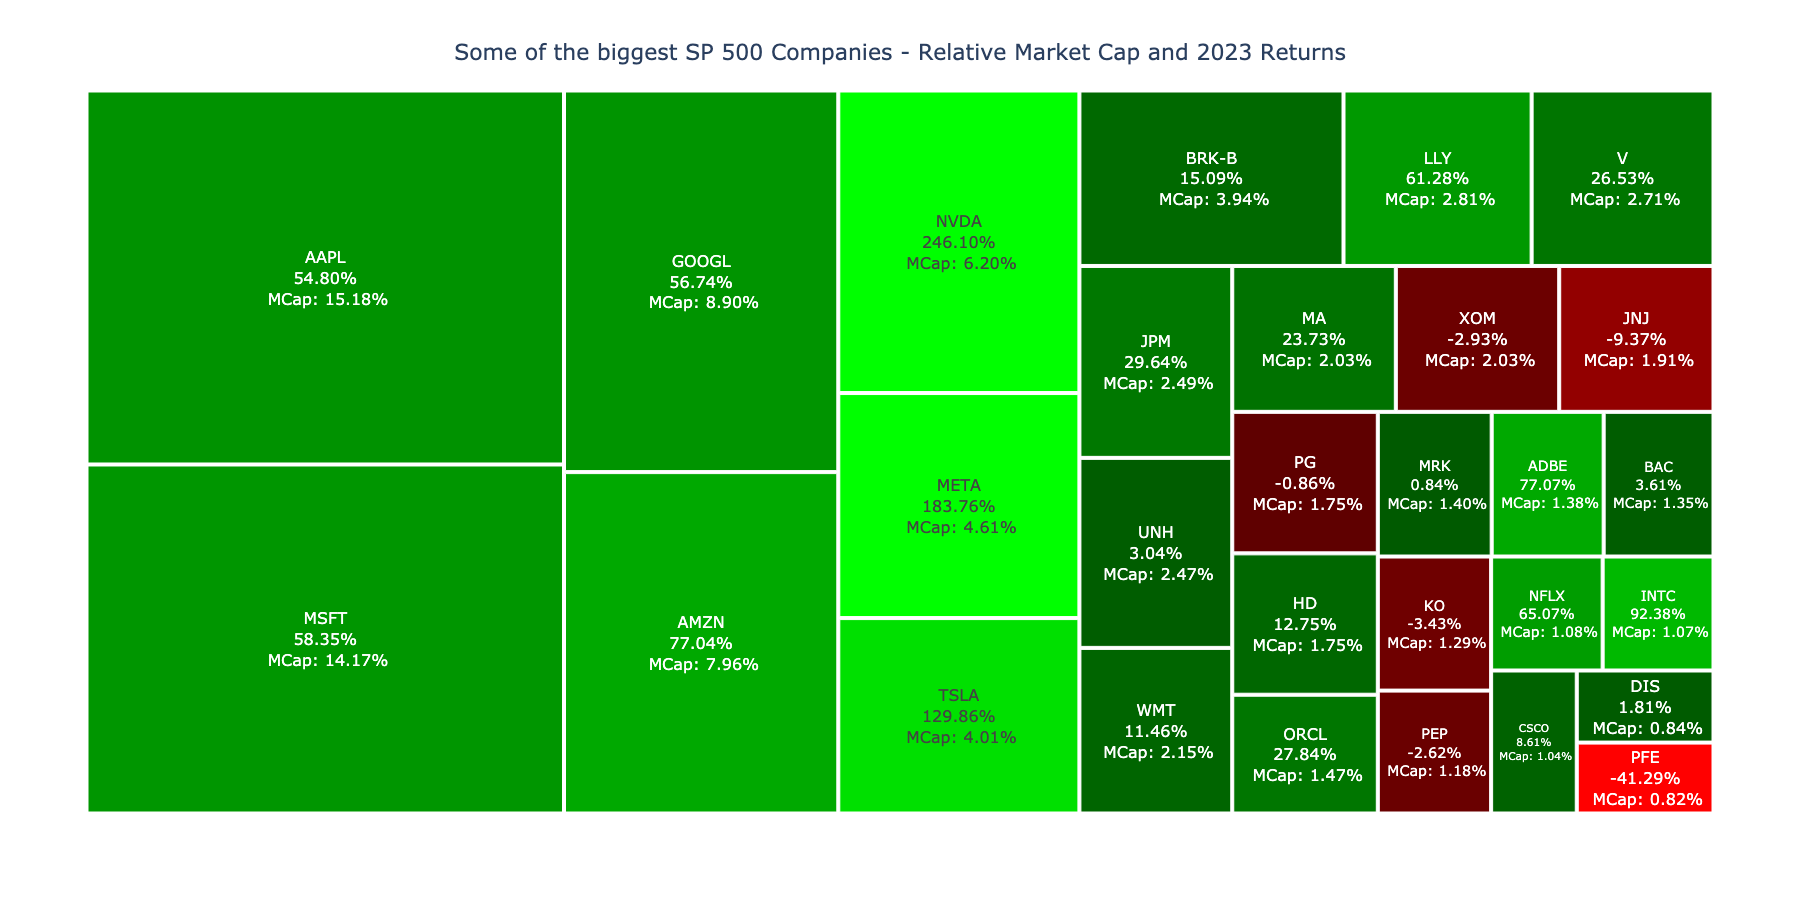

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import numpy as np
from datetime import datetime
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import plotly.express as px
import matplotlib.font_manager as fm
from matplotlib import rcParams

# Set the font
font = 'sans-serif'  
rcParams['font.family'] = font
rcParams['font.size'] = 12


companies = ["apple", "microsoft", "amazon", "nvidia", "tesla", "alphabet-google", "berkshire-hathaway", "meta-platforms", "united-health", "exxon-mobil",
              "eli-lilly", "johnson-and-johnson", "jp-morgan-chase", "visa", "procter-and-gamble", "mastercard", "bank-of-america", "home-depot", "pfizer", "walmart",
                "walt-disney", "pepsico", "coca-cola", "netflix", "adobe", "intel", "cisco", "oracle", "merck"]

tickers = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA", "GOOGL", "BRK-B", "META", "UNH", "XOM", "LLY", "JNJ", "JPM", "V", "PG", "MA", "BAC", "HD", "PFE",
            "WMT", "DIS", "PEP", "KO", "NFLX", "ADBE", "INTC", "CSCO", "ORCL", "MRK"]


Market_cap = np.zeros(len(tickers))
ret_2023 = np.zeros(len(tickers))

for index,company in enumerate(companies):

    # URL of the webpage containing the table
    url = f"https://companiesmarketcap.com/{company}/marketcap/"

    # Send a request to the website
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table in the HTML
    table = soup.find('table')

    # Convert the table to a DataFrame
    MarketCap = pd.read_html(str(table))[0]
    MarketCap.drop("Change", axis=1, inplace=True)

    # Function to convert market cap to billions
    def convert_to_billions(value):
        if 'T' in value:
            return float(value.replace('$', '').replace('T', '')) * 1000
        elif 'B' in value:
            return float(value.replace('$', '').replace('B', ''))
        else:
            return float(value)

    # Apply the conversion to the 'Market cap' column
    MarketCap['Market cap'] = MarketCap['Market cap'].apply(convert_to_billions)

    Market_cap[index] = MarketCap['Market cap'][0]

    stock_data = yf.download(tickers[index], start="2023-01-01", end=datetime.now().strftime("%Y-%m-%d"), progress=False)

    start_price = stock_data['Adj Close'].iloc[0]
    end_price = stock_data['Adj Close'].iloc[-1]
    
    return_2023 = (end_price - start_price) / start_price
    ret_2023[index] = return_2023

# Create DataFrame
df = pd.DataFrame({'ticker': tickers, 'marketcap': Market_cap, 'return': ret_2023})
df['% mkt cap'] = df['marketcap'] / df['marketcap'].sum()

# Function to assign color based on return value
def return_to_color(return_val, returns):
    min_return, max_return = min(returns), max(returns)
    if return_val >= 0:
        green_intensity = int(255 * (return_val / max_return)+90)
        return f'rgb(0,{green_intensity},0)'
    else:
        red_intensity = int(255 * (abs(return_val) / abs(min_return))+90)
        return f'rgb({red_intensity},0,0)'
    
# Apply color mapping function to create 'color' column
df['color'] = df['return'].apply(lambda x: return_to_color(x, df['return']))

# Create the color_discrete_map
color_discrete_map = {color: color for color in df['color'].unique()}

# Create the treemap
fig = px.treemap(df, path=['ticker'], values='% mkt cap', color='color',
                 color_discrete_map=color_discrete_map,
                 custom_data=['return', '% mkt cap'])

# Update layout with specified size
fig.update_layout(title_text='Some of the biggest SP 500 Companies - Relative Market Cap and 2023 Returns',
                  title_x=0.5, title_y=0.95, width=1800, height=900,
                      title_font_size=22)

# Center the text in the rectangles
fig.update_traces(textinfo="label+text+value", texttemplate='%{label}<br>%{customdata[0]:.2%}<br> MCap: %{customdata[1]:.2%}',
                  textposition='middle center', textfont_size=16)

# Display the graph
fig.show(renderer='png')